
# Housing Prices vs. Unemployment Trends in California

This notebook replicates the analysis and visualisation workflow described in the accompanying report.  It processes three datasets:

- `fhfa_hpi.csv` (FHFA House‑Price Index)【529491019350522†L81-L85】;
- `kaggle_real_estate.csv` (Zillow median home values, days on market, price cuts);
- `laus.csv` (Local Area Unemployment Statistics for California)【991720848600251†L84-L105】.

The notebook performs the following steps:

1. Loads and cleans each dataset.
2. Merges them on a common monthly date column.
3. Computes derived variables (percentage changes and categorical groups).
4. Filters subsets of interest (pandemic period, unemployment thresholds, price tiers, combined conditions, seasonal subsets).
5. Sorts the data in various ways to highlight extremes.
6. Generates a suite of visualisations.
7. Builds pivot tables and demonstrates stacking/unstacking.
8. Computes correlations to summarise relationships.

Run all cells sequentially to reproduce the analysis and figures.


In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_rows', 10)
%matplotlib inline


In [15]:

# Load data from local files (update paths as needed)
hpi = pd.read_csv('Databases/fhfa_hpi.csv')
zillow = pd.read_csv('Databases/kaggle_real_estate.csv')
laus = pd.read_csv('Databases/laus.csv')

# Preview basic structures
print('HPI shape:', hpi.shape)
print('Zillow shape:', zillow.shape)
print('LAUS shape:', laus.shape)


HPI shape: (132363, 10)
Zillow shape: (895, 232)
LAUS shape: (215048, 12)


In [16]:

# Filter to California state level and average duplicate entries
hpi_ca = hpi[(hpi['level'].str.lower() == 'state') & (hpi['place_name'] == 'California')].copy()
# Create date column (YYYY-MM-01)
hpi_ca['date'] = pd.to_datetime(hpi_ca['yr'].astype(str) + '-' + hpi_ca['period'].astype(str).str.zfill(2) + '-01')
# Average index across duplicates for the same date
hpi_ca = hpi_ca[['date', 'index_sa']].groupby('date', as_index=False).mean()

hpi_ca.head()


,date,index_sa
0,1975-01-01,NaN
1,1975-02-01,NaN
2,1975-03-01,NaN
3,1975-04-01,NaN
4,1976-01-01,NaN


In [17]:

# Identify date-metric columns containing metrics (e.g., '2018-02-HomeValue')
value_cols = [col for col in zillow.columns if '-' in col and col.count('-') >= 2]

# Melt wide columns into long format with date and metric fields
zillow_long = zillow.melt(id_vars=['RegionID','RegionName','StateName'],
                          value_vars=value_cols,
                          var_name='metric_date', value_name='value')

# Split 'metric_date' into date and metric name
zillow_long[['date_str','metric']] = zillow_long['metric_date'].str.extract(r'^(\d{4}-\d{2})-(.*)$')
zillow_long['date'] = pd.to_datetime(zillow_long['date_str'] + '-01')

# Filter to California rows (state code CA)
zillow_ca = zillow_long[zillow_long['StateName'] == 'CA']

# Pivot to get average values per date for each metric
zillow_pivot = zillow_ca.pivot_table(index='date', columns='metric', values='value', aggfunc='mean').reset_index()
# Rename columns for clarity
zillow_pivot.rename(columns={'HomeValue':'home_value', 'DaysPending':'days_pending', 'CutRaw':'cut_raw'}, inplace=True)

zillow_pivot.head()


metric,date,cut_raw,days_pending,home_value
0,2018-02-01,16109.523810,40.642857,426126.500684
1,2018-03-01,16143.190476,37.321429,430110.851559
2,2018-04-01,17580.404762,36.285714,433698.712450
3,2018-05-01,17914.357143,34.321429,437143.119717
4,2018-06-01,17221.571429,38.892857,439843.879635


In [18]:

# Filter to California state and seasonally adjusted values
laus_state = laus[(laus['Area Type'] == 'State') & 
                  (laus['Area Name'] == 'California') &
                  (laus['Seasonally Adjusted(Y/N)'] == 'Y')].copy()

# Map month names to numbers
month_map = {m: i for i, m in enumerate(['January','February','March','April','May','June','July','August','September','October','November','December'], start=1)}
laus_state['month_num'] = laus_state['Month'].map(month_map)
laus_state['date'] = pd.to_datetime(laus_state['Year'].astype(str) + '-' + laus_state['month_num'].astype(str).str.zfill(2) + '-01')

# Convert unemployment rate to numeric
laus_state['unemployment_rate'] = pd.to_numeric(laus_state['Unemployment Rate'], errors='coerce')
laus_state = laus_state[['date', 'unemployment_rate']].dropna().sort_values('date')

laus_state.head()


,date,unemployment_rate
1,1976-01-01,9.2
3,1976-02-01,9.2
5,1976-03-01,9.1
7,1976-04-01,9.1
9,1976-05-01,9.0


In [19]:

# Merge the HPI, LAUS, and Zillow tables on date
merged = hpi_ca.merge(laus_state, on='date', how='inner').merge(zillow_pivot, on='date', how='inner')
# Sort by date
merged = merged.sort_values('date').reset_index(drop=True)

# Display merged head
merged.head()


,date,index_sa,unemployment_rate,cut_raw,days_pending,home_value
0,2018-02-01,274.160,4.3,16109.523810,40.642857,426126.500684
1,2018-03-01,277.525,4.3,16143.190476,37.321429,430110.851559
2,2018-04-01,279.715,4.2,17580.404762,36.285714,433698.712450
3,2019-01-01,281.885,4.3,13517.333333,68.965517,448079.284427
4,2019-02-01,284.870,4.3,14054.809524,62.827586,448205.444633


In [20]:

# Percentage changes
merged['hpi_pct_change'] = merged['index_sa'].pct_change()
merged['unemp_pct_change'] = merged['unemployment_rate'].pct_change()
merged['home_value_pct_change'] = merged['home_value'].pct_change()
merged['days_pending_pct_change'] = merged['days_pending'].pct_change()

# Year, quarter, month
merged['year'] = merged['date'].dt.year
merged['month'] = merged['date'].dt.month
merged['quarter'] = merged['date'].dt.quarter

# Categorical groups for unemployment and price tiers
merged['unemp_group'] = pd.cut(merged['unemployment_rate'], bins=[-np.inf, 5, 7, np.inf], labels=['low','medium','high'])
quantiles = merged['home_value'].quantile([0.25, 0.75]).values
bins_price = [-np.inf, quantiles[0], quantiles[1], np.inf]
merged['price_tier'] = pd.cut(merged['home_value'], bins=bins_price, labels=['low','middle','high'])

merged.head()


,date,index_sa,unemployment_rate,cut_raw,days_pending,home_value,hpi_pct_change,unemp_pct_change,home_value_pct_change,days_pending_pct_change,year,month,quarter,unemp_group,price_tier
0,2018-02-01,274.160,4.3,16109.523810,40.642857,426126.500684,NaN,NaN,NaN,NaN,2018,2,1,low,low
1,2018-03-01,277.525,4.3,16143.190476,37.321429,430110.851559,0.012274,0.000000,0.009350,-0.081722,2018,3,1,low,low
2,2018-04-01,279.715,4.2,17580.404762,36.285714,433698.712450,0.007891,-0.023256,0.008342,-0.027751,2018,4,2,low,low
3,2019-01-01,281.885,4.3,13517.333333,68.965517,448079.284427,0.007758,0.023810,0.033158,0.900624,2019,1,1,low,low
4,2019-02-01,284.870,4.3,14054.809524,62.827586,448205.444633,0.010589,0.000000,0.000282,-0.089000,2019,2,1,low,low


In [21]:

# 1. Pandemic period (2020+)
pandemic_subset = merged[merged['date'] >= '2020-01-01']

# 2. Unemployment thresholds
low_unemp = merged[merged['unemp_group'] == 'low']
medium_unemp = merged[merged['unemp_group'] == 'medium']
high_unemp = merged[merged['unemp_group'] == 'high']

# 3. Price tiers
low_price = merged[merged['price_tier'] == 'low']
middle_price = merged[merged['price_tier'] == 'middle']
high_price = merged[merged['price_tier'] == 'high']

# 4. Combined conditions (unemployment >6% and negative HPI growth)
combined_cond = merged[(merged['unemployment_rate'] > 6) & (merged['hpi_pct_change'] < 0)]

# 5. Seasonal subsets (Quarter 1 and Quarter 3)
q1_subset = merged[merged['quarter'] == 1]
q3_subset = merged[merged['quarter'] == 3]

# Print counts for each subset
print('Pandemic subset:', len(pandemic_subset))
print('Low unemployment:', len(low_unemp))
print('Medium unemployment:', len(medium_unemp))
print('High unemployment:', len(high_unemp))
print('Low price tier:', len(low_price))
print('Middle price tier:', len(middle_price))
print('High price tier:', len(high_price))
print('Combined condition rows:', len(combined_cond))
print('Quarter 1 subset:', len(q1_subset))
print('Quarter 3 subset:', len(q3_subset))


Pandemic subset: 20
Low unemployment: 16
Medium unemployment: 6
High unemployment: 5
Low price tier: 7
Middle price tier: 13
High price tier: 7
Combined condition rows: 0
Quarter 1 subset: 20
Quarter 3 subset: 0


In [26]:

# Add deviation from mean unemployment for sorting
merged['unemp_deviation'] = (merged['unemployment_rate'] - merged['unemployment_rate'].mean()).abs()

# Sorting examples
sort_date_desc = merged.sort_values('date', ascending=False).head(5)
sort_home_desc = merged.sort_values('home_value', ascending=False).head(5)
sort_unemp_asc = merged.sort_values('unemployment_rate').head(5)
sort_hpi_growth = merged.sort_values('hpi_pct_change', ascending=False).head(5)
sort_unemp_dev = merged.sort_values('unemp_deviation', ascending=False).head(5)

# Display the sorted heads
print('Recent months:', sort_date_desc[['date','index_sa','unemployment_rate','home_value']])
print('Highest home values:', sort_home_desc[['date','home_value','index_sa','unemployment_rate']])
print('Lowest unemployment:', sort_unemp_asc[['date','unemployment_rate','home_value','index_sa']])
print('Highest HPI growth:', sort_hpi_growth[['date','hpi_pct_change','index_sa','unemployment_rate']])
print('Largest unemployment deviations:', sort_unemp_dev[['date','unemployment_rate','unemp_deviation','index_sa','home_value']])


Recent months:          date  index_sa  unemployment_rate     home_value
26 2024-04-01   426.555                5.2  615631.512863
25 2024-03-01   422.395                5.1  611862.298184
24 2024-02-01   419.230                5.1  609715.237576
23 2024-01-01   417.230                5.1  609553.845818
22 2023-04-01   413.215                4.5  587404.451859
Highest home values:          date     home_value  index_sa  unemployment_rate
18 2022-04-01  617703.017466   396.055                4.3
26 2024-04-01  615631.512863   426.555                5.2
25 2024-03-01  611862.298184   422.395                5.1
24 2024-02-01  609715.237576   419.230                5.1
23 2024-01-01  609553.845818   417.230                5.1
Lowest unemployment:         date  unemployment_rate     home_value  index_sa
6 2019-04-01                4.1  449427.792805   291.445
2 2018-04-01                4.2  433698.712450   279.715
5 2019-03-01                4.2  448768.263765   287.910
0 2018-02-01       

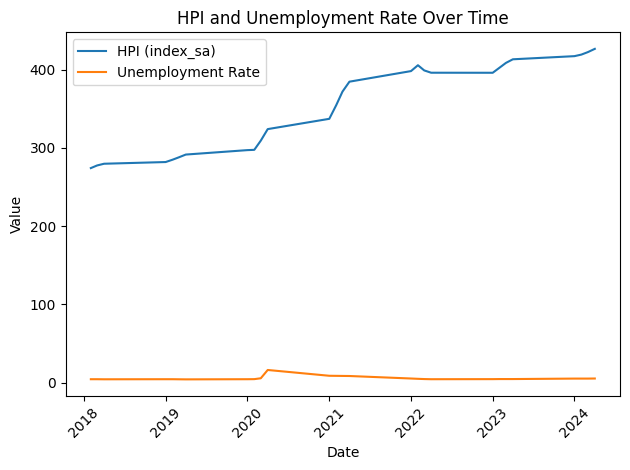

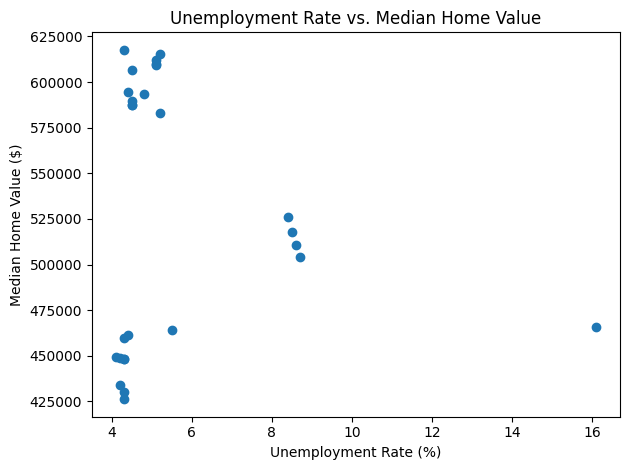

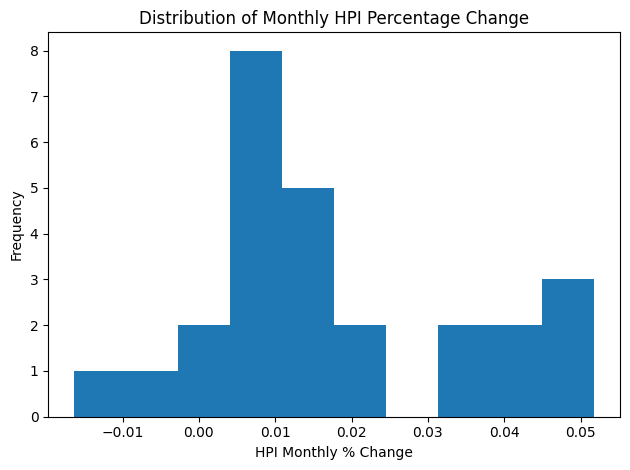

<Figure size 640x480 with 0 Axes>

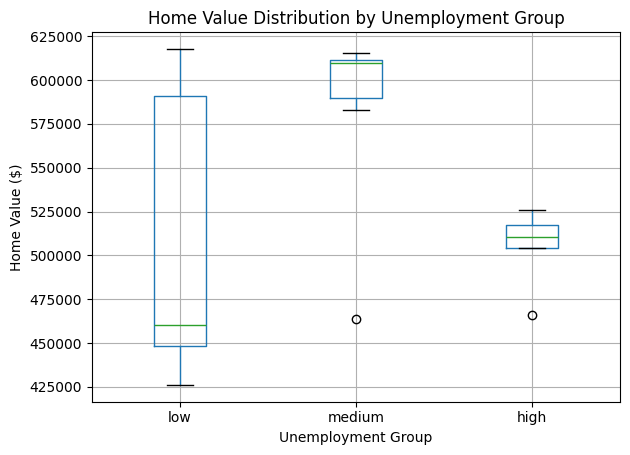

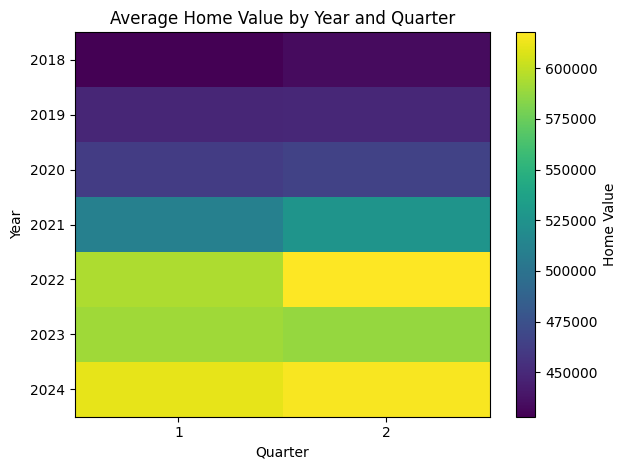

In [27]:

# 1. HPI and Unemployment Rate over Time
plt.figure()
plt.plot(merged['date'], merged['index_sa'], label='HPI (index_sa)')
plt.plot(merged['date'], merged['unemployment_rate'], label='Unemployment Rate')
plt.legend()
plt.title('HPI and Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Scatter plot: Unemployment vs Home Value
plt.figure()
plt.scatter(merged['unemployment_rate'], merged['home_value'])
plt.title('Unemployment Rate vs. Median Home Value')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Median Home Value ($)')
plt.tight_layout()
plt.show()

# 3. Histogram of HPI percentage change
plt.figure()
plt.hist(merged['hpi_pct_change'].dropna(), bins=10)
plt.title('Distribution of Monthly HPI Percentage Change')
plt.xlabel('HPI Monthly % Change')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 4. Boxplot of Home Value by Unemployment Group
plt.figure()
merged.boxplot(column='home_value', by='unemp_group')
plt.title('Home Value Distribution by Unemployment Group')
plt.suptitle('')
plt.xlabel('Unemployment Group')
plt.ylabel('Home Value ($)')
plt.tight_layout()
plt.show()

# 5. Heatmap of Average Home Value by Year and Quarter
pivot_home = merged.pivot_table(index='year', columns='quarter', values='home_value', aggfunc='mean')
plt.figure()
plt.imshow(pivot_home, aspect='auto')
plt.title('Average Home Value by Year and Quarter')
plt.xlabel('Quarter')
plt.ylabel('Year')
plt.xticks(ticks=np.arange(len(pivot_home.columns)), labels=pivot_home.columns)
plt.yticks(ticks=np.arange(len(pivot_home.index)), labels=pivot_home.index)
plt.colorbar(label='Home Value')
plt.tight_layout()
plt.show()


In [31]:

# Pivot 1: Average home value by year and quarter
pivot1 = merged.pivot_table(index='year', columns='quarter', values='home_value', aggfunc='mean')
print('Pivot1 - Home value by year and quarter:')
display(pivot1)

# Pivot 2: Average unemployment rate by year and quarter
pivot2 = merged.pivot_table(index='year', columns='quarter', values='unemployment_rate', aggfunc='mean')
print('Pivot2 - Unemployment rate by year and quarter:')
display(pivot2)

# Pivot 3: Average days pending by unemployment group and price tier
pivot3 = merged.pivot_table(index='unemp_group', columns='price_tier', values='days_pending', aggfunc='mean')
print('Pivot3 - Days pending by unemp group and price tier:')
display(pivot3)

# Pivot 4: Multi-index pivot of home value by year and unemp group, stack and unstack
pivot4 = merged.pivot_table(index=['year','unemp_group'], columns='price_tier', values='home_value', aggfunc='mean')
stacked = pivot4.stack()
unstacked = stacked.unstack(level=1)
print('Pivot4 - Stacked and unstacked:')
display(stacked)
display(unstacked)

# Pivot 5: Count of records by unemployment group and price tier
pivot5 = merged.pivot_table(index='unemp_group', columns='price_tier', values='date', aggfunc='count')
print('Pivot5 - Counts by unemp group and price tier:')
display(pivot5)


Pivot1 - Home value by year and quarter:


quarter,1,2
year,,
2018,428118.676121,433698.712450
2019,448350.997608,449427.792805
2020,461649.766153,465766.869179
2021,510792.831820,525874.028486
2022,594364.286820,617703.017466
2023,590488.690366,587404.451859
2024,610377.127193,615631.512863


Pivot2 - Unemployment rate by year and quarter:


quarter,1,2
year,,
2018,4.300000,4.2
2019,4.266667,4.1
2020,4.733333,16.1
2021,8.600000,8.4
2022,4.833333,4.3
2023,4.466667,4.5
2024,5.100000,5.2


Pivot3 - Days pending by unemp group and price tier:


/var/folders/1h/wv40s9sd7q3064vh12c0_gsh0000gn/T/ipykernel_2192/4009990317.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot3 = merged.pivot_table(index='unemp_group', columns='price_tier', values='days_pending', aggfunc='mean')


price_tier,low,middle,high
unemp_group,,,
low,50.065271,47.373563,33.609195
medium,NaN,39.379310,45.681452
high,NaN,32.006897,NaN


Pivot4 - Stacked and unstacked:


/var/folders/1h/wv40s9sd7q3064vh12c0_gsh0000gn/T/ipykernel_2192/4009990317.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot4 = merged.pivot_table(index=['year','unemp_group'], columns='price_tier', values='home_value', aggfunc='mean')


year  unemp_group  price_tier
2018  low          low           429978.688231
2019  low          low           448620.196408
2020  low          middle        460551.875165
      medium       middle        463845.548129
      high         middle        465766.869179
                                     ...      
2022  low          high          612035.713214
      medium       middle        583184.876710
2023  low          middle        588147.257035
                   high          594428.751854
2024  medium       high          611690.723610
Length: 12, dtype: float64

unemp_group                low         medium           high
year price_tier                                             
2018 low         429978.688231            NaN            NaN
2019 low         448620.196408            NaN            NaN
2020 middle      460551.875165  463845.548129  465766.869179
2021 middle                NaN            NaN  514563.130986
2022 middle      593539.574788  583184.876710            NaN
     high        612035.713214            NaN            NaN
2023 middle      588147.257035            NaN            NaN
     high        594428.751854            NaN            NaN
2024 high                  NaN  611690.723610            NaN

Pivot5 - Counts by unemp group and price tier:


/var/folders/1h/wv40s9sd7q3064vh12c0_gsh0000gn/T/ipykernel_2192/4009990317.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot5 = merged.pivot_table(index='unemp_group', columns='price_tier', values='date', aggfunc='count')


price_tier,low,middle,high
unemp_group,,,
low,7,6,3
medium,0,2,4
high,0,5,0


In [32]:

# Correlations
corr_hpi_unemp = merged['index_sa'].corr(merged['unemployment_rate'])
corr_home_unemp = merged['home_value'].corr(merged['unemployment_rate'])
corr_hpi_pchange_unemp = merged['hpi_pct_change'].corr(merged['unemployment_rate'])
corr_home_pchange_unemp = merged['home_value_pct_change'].corr(merged['unemployment_rate'])

print('Correlation between HPI index and unemployment rate:', corr_hpi_unemp)
print('Correlation between median home value and unemployment rate:', corr_home_unemp)
print('Correlation between HPI monthly % change and unemployment rate:', corr_hpi_pchange_unemp)
print('Correlation between home value monthly % change and unemployment rate:', corr_home_pchange_unemp)


Correlation between HPI index and unemployment rate: 0.0199626228655766
Correlation between median home value and unemployment rate: -0.10879709038967748
Correlation between HPI monthly % change and unemployment rate: 0.710518823796223
Correlation between home value monthly % change and unemployment rate: 0.12238354239718473
